In [81]:
import qulacs
from qulacs import QuantumState, QuantumCircuit
from qulacs.state import partial_trace
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
# [0, k): Charlie
# [k, 2k): Alice
# [2k, n+k): Black hole -> [k, n+k)
class YoungBlackHole():
    def __init__(self, n, k, dynamics, depth=-1):
        self.n = n
        self.k = k
        self.size = n + k
        self.dynamics = dynamics
        self.depth=depth
        self.reset()
    def reset(self):
        n, k = self.n, self.k
        dynamics = self.dynamics
        depth = self.depth
        self.state = QuantumState(n + k)
        self.circuit = QuantumCircuit(n + k)
        for i in range(k):
            self.circuit.add_H_gate(i)
            self.circuit.add_CNOT_gate(i, i + k)
        if dynamics == "lrc":
            self.add_LRC(k, n+k, depth)
        elif dynamics == "haar":
            self.circuit.add_random_unitary_gate(list(range(k, n+k)))
        elif dynamics == "heisenberg":
            self.add_Heisenberg()
    def update(self):
        self.circuit.update_quantum_state(self.state)
    def add_LRC(self, l, r, depth):
        assert depth>=0 
        for d in range(depth):
            for i in range(l + d % 2, r - 1, 2):
                self.circuit.add_random_unitary_gate([i, i + 1])
    def add_Heisenberg(self):
        pass
    # l1 norm
    def L1(self, l):
        n, k = self.n, self.k
        mat_size = pow(2, n+k-l)
        trace = partial_trace(self.state, list(range(n + k - l, n + k)))
        return npl.norm(trace.get_matrix() - np.identity(mat_size)/mat_size, 'nuc')
    # mutual information
    def MI(self, l):
        n, k = self.n, self.k
        AB = partial_trace(self.state, list(range(k, n + k - l)))
        A = partial_trace(self.state, list(range(k, n + k)))
        B = partial_trace(self.state, list(range(0, n + k -l)))
        return self.S(A)+self.S(B)-self.S(AB)
    def S(self, rho):
        if rho is None:
            return 0
        mat = rho.get_matrix()
        eig_vals = npl.eigvalsh(mat)
        return -(eig_vals * np.log2(eig_vals+0.000001)).sum()

In [94]:
# simulator for young black hole
def simulate(model, l_max, iter_num):
    data_MI = np.zeros((l_max + 1, iter_num))
    data_L1 = np.zeros((l_max + 1, iter_num))
    for l in range(l_max + 1):
        mat_size = pow(2, n+k-l)
        for i in range(iter_num):
            if i%10 == 0: print(f"l={l}:i-th iteration")
            state = QuantumState(model.size)
            model.update()
            data_MI[l][i] = model.MI(l)
            data_L1[l][i] = model.L1(l)
            model.reset()
    return data_MI, data_L1
def plot_graph(data):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(np.average(data, axis=1))
    return fig

In [95]:
n, k, l_max = 9, 1, 9
model = YoungBlackHole(n, k, 'haar')
data_MI, data_L1 = simulate(model, l_max, 1)

l=0:i-th iteration
l=1:i-th iteration
l=2:i-th iteration
l=3:i-th iteration
l=4:i-th iteration
l=5:i-th iteration
l=6:i-th iteration
l=7:i-th iteration
l=8:i-th iteration
l=9:i-th iteration


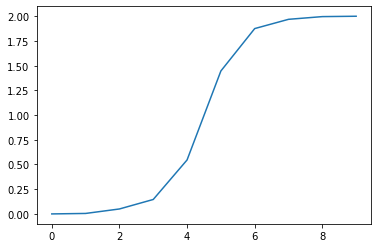

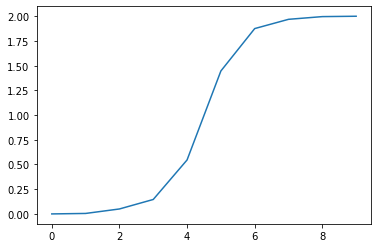

In [96]:
plot_graph(data_MI)